In [23]:
import os
import re
import glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import spacy
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
import pdfplumber
import docx
import nltk
import pandas as pd

# Download required NLTK data
nltk.download('stopwords', quiet=True)
STOPWORDS = set(stopwords.words('english'))

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_md")
except Exception:
    import spacy.cli
    spacy.cli.download("en_core_web_md")
    nlp = spacy.load("en_core_web_md")

# Paths
RESUME_FOLDER = "HR"   # folder with your 110 resumes
TOP_N = 10


In [24]:
def extract_text_from_pdf(path):
    text = ""
    try:
        with pdfplumber.open(path) as pdf:
            for page in pdf.pages:
                text += (page.extract_text() or "") + "\n"
    except Exception as e:
        print(f"⚠️ Failed to read {path}: {e}")
    return text

def extract_text_from_docx(path):
    doc = docx.Document(path)
    return "\n".join([p.text for p in doc.paragraphs if p.text.strip()])

def extract_text_from_txt(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def extract_text(path):
    ext = os.path.splitext(path)[1].lower()
    if ext == ".pdf":
        return extract_text_from_pdf(path)
    elif ext == ".docx":
        return extract_text_from_docx(path)
    elif ext == ".txt":
        return extract_text_from_txt(path)
    else:
        return ""


In [25]:
def clean_and_lemmatize(text):
    if not text:
        return ""
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'[^A-Za-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip().lower()

    doc = nlp(text)
    lemmas = [
        token.lemma_
        for token in doc
        if token.is_alpha and not token.is_stop and token.lemma_ not in STOPWORDS
    ]
    return " ".join(lemmas)


In [26]:
def get_embedding(text):
    if not text or len(text.strip()) == 0:
        return np.zeros(nlp.vocab.vectors_length)
    return nlp(text).vector

def cosine_sim(a, b):
    if not np.any(a) or not np.any(b):
        return 0.0
    return cosine_similarity([a], [b])[0][0]


In [27]:
def load_resumes(folder):
    files = []
    for ext in ("*.pdf", "*.docx", "*.txt"):
        files.extend(glob.glob(os.path.join(folder, ext)))

    resumes = {}
    for i, f in enumerate(tqdm(files, desc="Extracting resumes")):
        text = extract_text(f)
        if not text.strip():
            continue
        cleaned = clean_and_lemmatize(text)
        candidate_name = f"Candidate_{i+1:03d}"  # auto numbering
        resumes[os.path.basename(f)] = {
            "name": candidate_name,
            "raw": text,
            "clean": cleaned
        }
    return resumes


In [28]:
job_description_text = """
We are hiring an HR Consultant to understand company staffing needs and create plans to hire and manage employees effectively.
The role includes improving hiring and onboarding processes, tracking employee performance, and ensuring company policies follow labor laws.
Strong communication, teamwork, and problem-solving skills are needed to build a positive and productive workplace.
"""


In [29]:
def rank_resumes(job_description, resumes_dict, top_n=TOP_N):
    print("\nRanking resumes...\n")
    job_clean = clean_and_lemmatize(job_description)
    job_vec = get_embedding(job_clean)

    scores = []
    for data in tqdm(resumes_dict.values(), desc="Comparing"):
        vec = get_embedding(data["clean"])
        score = cosine_sim(job_vec, vec)
        scores.append((data["name"], score))

    scores.sort(key=lambda x: x[1], reverse=True)

    print("\n=== 🏆 Top HR Candidates ===")
    for i, (name, score) in enumerate(scores[:top_n], 1):
        print(f"{i}. {name} → {score:.4f}")

    # Plot graph
    top_names = [x[0] for x in scores[:top_n]]
    top_scores = [x[1] for x in scores[:top_n]]
    plt.figure(figsize=(10, 5))
    plt.barh(top_names[::-1], top_scores[::-1])
    plt.title("Top HR Candidates")
    plt.xlabel("Cosine Similarity Score")
    plt.show()

    # Save to CSV
    df = pd.DataFrame(scores, columns=["Candidate", "Similarity Score"])
    df.to_csv("HR_RankingResults.csv", index=False)
    print("\n💾 Results saved to HR_RankingResults.csv")

    return scores


Extracting resumes: 100%|████████████████████████████████████████████████████████████| 110/110 [01:36<00:00,  1.14it/s]



Ranking resumes...



Comparing: 100%|█████████████████████████████████████████████████████████████████████| 110/110 [00:12<00:00,  8.72it/s]


=== 🏆 Top HR Candidates ===
1. Candidate_010 → 0.9662
2. Candidate_026 → 0.9650
3. Candidate_047 → 0.9640
4. Candidate_075 → 0.9639
5. Candidate_103 → 0.9637
6. Candidate_104 → 0.9629
7. Candidate_066 → 0.9628
8. Candidate_098 → 0.9623
9. Candidate_037 → 0.9620
10. Candidate_095 → 0.9614


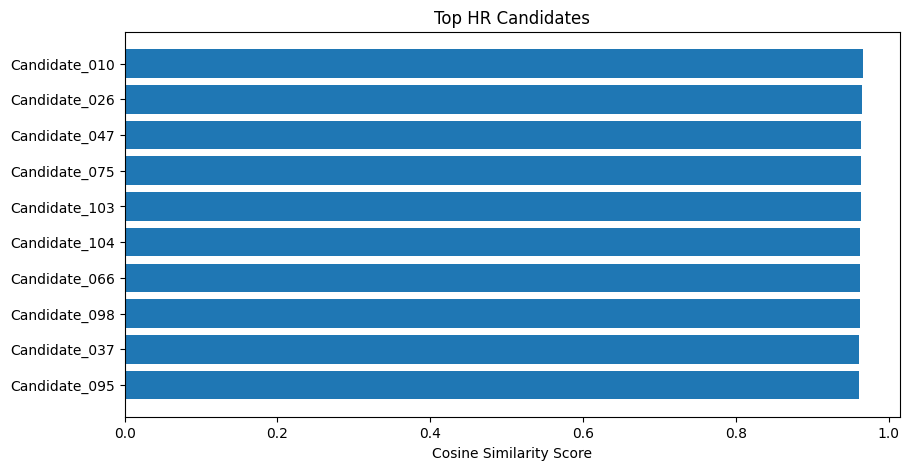


💾 Results saved to HR_RankingResults.csv


In [30]:
resumes_dict = load_resumes(RESUME_FOLDER)

if not resumes_dict:
    print("❌ No extractable resumes found in folder!")
else:
    ranking = rank_resumes(job_description_text, resumes_dict, top_n=TOP_N)


In [31]:
def view_resume(filename):
    if filename not in resumes_dict:
        print("Resume not found.")
        return
    data = resumes_dict[filename]
    print(f"\n--- {data['name']} ---")
    print(data["raw"][:1200], "...")

# Example
if resumes_dict:
    first_file = list(resumes_dict.keys())[0]
    view_resume(first_file)



--- Candidate_001 ---
HR PERSONNEL ASSISTANT
Summary
I am a U.S. citizen who is authorized to work in the US for any employer. I have worked 8 years as an Office Clerk, 2 years as a Student
Intern/Office Assistant, and 4 years as a Contractor. I am applying for the Data Entry Clerk position (Advert ID# 224278 Advert ID# 224278).
My skills and experiences include: Administrative Support, Auditing, File Management, Meeting Facilitation, Office Materials Management, &
Inventory Management.
Highlights
COMPUTER SKILLS: Microsoft Word, MS Excel, MS Outlook, MS PowerPoint, PeopleSoft. TYPING SKILLS: 40-60 WPM.
ADDITIONAL SKILLS: Administrative Support, Auditing, Clerical, Copy, Customer Service, Data Entry, Delivery, Documentation, Fax, File
Management, Letters, Meeting Facilitation, Organizational Skills, Proofreading, Receptionist, Research, Scanning, Scheduling, Secretarial,
Telephone Skills, Office Equipment Maintenance, and Inventory Management.
Experience
Company Name City , State HR P